# Defining the Anti-Ecliptic

## Imports and Functions

In [222]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import matplotlib.pyplot as plt
import math

import star_chart_spherical_projection as scsp
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_sun, Angle, Longitude
from sunpy.coordinates import frames, sun

# I want get_sun to shut up so ignoring warnings:

import warnings

warnings.simplefilter('ignore', UserWarning)



def SunRiseSet(jd, SunAlt, deg):
    
    '''
    A function to create a list of indices where the Sun rises and sets in a given year. 
    This is useful for making sure we're tracking nightly, visible motion of the decans.
    Inputs: 
        jd = Julian date
        SunAlt = the altitude of the Sun
    Outputs:
        sunriseset = indices of sunrize and sunset in the jd & date columns
    '''
    
    sunriseset = []
    for i in range(360, len(jd), 360):
        temp = []
        for j in range(i - 360, i):
            if SunAlt[j] <= deg + 0.4 and SunAlt[j] >= deg - 0.4:
                if len(temp) == 0: 
                    temp.append(j)
                elif temp[-1] != j - 1:
                    temp.append(j)
        sunriseset.append(temp)
    return sunriseset




# def nightHourLength(jd, sunriseset):
#     hrlen = [];
#     dhour = 0.04166666674427688

#     for i in sunriseset:
#         night = jd[i[1]] - jd[i[0]]
#         hrlen.append((night/dhour) * (60/12))
#     return(hrlen)


def nightHourLength(jd, sunrise, sunset):
    hrlen = [];
    dhour = 0.04166666674427688

    for i in range(0,len(sunrise)-1):
        night = jd[sunrise[i + 1][0]] - jd[sunset[i][1]]
        hrlen.append((night/dhour) * (60/12))
    return(hrlen)
# Import Decan Data

def ImportDecanData(direct, filename):
    '''
    A function to import data from a decanOpy-generated .txt file. 
    Inputs: 
        direct = string with the directory where the .txt file is located
        filename = string with name of file (name + month + year)
    Outputs:
        jd = Julian date
        date = human readable date
        DecAz = the azimuth of the decan
        DecAlt = the altitude of the decan
        SunAz = the azimuth of the Sun
        SunAlt = the altitude of the Sun
    '''
    jd = []
    date = []
    SunAz = []
    SunAlt = []
    # Import Single Object
    with open(direct + filename) as csv_file:
        rownum = 0;
        csv_reader = csv.reader(csv_file, delimiter='|')
        headers = next(csv_reader)
        num = int((len(headers) - 4)/2)
        DecAz = np.zeros((num, 131400))
        DecAlt = np.zeros((num, 131400))
        names = headers[4:]
        for row in csv_reader:
            # time info
            jd.append(float(row[0]))
            date.append(row[1])
            # solar info
            SunAz.append(float(row[2][0:-4]))
            SunAlt.append(float(row[3][0:-4]))
            # decan info
            for i in range(0, num):
                DecAz[i, rownum] = float(row[4 + i * 2][0:-4])
                DecAlt[i, rownum] = float(row[5 + i * 2][0:-4])
            rownum +=1        
    return(jd, date, SunAz, SunAlt, DecAz, DecAlt)


def JustDecanData(direct, filename):
    
    '''
    A function to import just the can data data from a decanOpy-generated .txt file. 
    Used for the MaxMinAltAz function.
    Inputs: 
        direct = string with the directory where the .txt file is located
        filename = string with name of file (name + month + year)
    Outputs:
        DecAz = the azimuth of the decan
        DecAlt = the altitude of the decan
    '''
    
    DecAz = []
    DecAlt = []
    # Import Single Object
    with open(direct + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='|')
        decan = next(csv_reader)[0]
        location = next(csv_reader)[0]
        trash = next(csv_reader)
        headers = next(csv_reader)
        for row in csv_reader:
            # decan info
            DecAz.append(float(row[2][0:-4]))
            DecAlt.append(float(row[3][0:-4]))
            # solar info
    return(DecAz, DecAlt)

def MaxMinAltAz(direct, filename, jd, sunriseset):
    
    '''
    A function to create lists of minimum and maximum azimuths and altitudes of the decan. 
    This is useful for making sure we're tracking nightly, visible motion of the decans.
    Inputs: 
        direct = string with the directory where the .txt file is located
        filename = string with name of file (name + month + year)
        jv = Julian date
        sunriseset = indices of sunrize and sunset in the jd & date columns
    Outputs:
        sunriseset = indices of sunrize and sunset in the jd & date columns
        days = list of indices when it's daylight 
        minaz, maxaz = minimum and maximum azimuths of the decan per night
        minalt, maxalt = minimum and maximum altitudes of the decan per night
        riseaz, setaz = azimuth of decan at rise & set
        risealt, setalt = altitude of decan at rise & set
    '''
    
    (DecAz, DecAlt) = JustDecanData(direct, filename)
    maxalt = []
    minalt = []
    maxaz = []
    minaz = []
    riseaz = []
    setaz = []
    risealt = []
    setalt = []
    days = []
    for i in range(0, int(len(jd)/360) - 2):
        sset = sunriseset[i][1]
        srise = sunriseset[i + 1][0]
        maxalt.append(max(DecAlt[sset:srise]))
        minalt.append(min(DecAlt[sset:srise]))
        maxaz.append(max(DecAz[sset:srise]))
        minaz.append(min(DecAz[sset:srise]))
        riseaz.append(DecAz[srise])
        setaz.append(DecAz[sset])
        risealt.append(DecAlt[srise])
        setalt.append(DecAlt[sset])
        days.append(DecAlt[srise:sset])
    return(days, minaz, maxaz, minalt, maxalt, riseaz, setaz, risealt, setalt)

## Re-do analysis

In [223]:
def StarRiseSet(jd, starAlt, deg):
    # create return arrays
    star_rise = np.zeros(int(len(jd)/360), dtype=int)
    star_set = np.zeros(int(len(jd)/360), dtype=int)
    # loop through each day
    for i in range(360, len(jd) + 1, 360):
        # isolate data for one day
        dailyStarAlt = starAlt[i - 360 : i]
        # is the star visible at the beginning of the day
        starVis = dailyStarAlt[0] > deg
        # make array of booleans
        bool_arr = dailyStarAlt > deg   
        # find two indices of change
        ind1 = np.argwhere(bool_arr != starVis)[0][0]
        ind2 = np.argwhere(bool_arr[ind1:]== starVis)[0][0] + ind1
        # assign indices
        if starVis:
            star_set[int((i-360)/360)] = int(-360 + i  + ind1)
            star_rise[int((i-360)/360)] = int(-360 + i  + ind2)
        else:
            star_set[int((i-360)/360)] = int(-360 + i  + ind2)
            star_rise[int((i-360)/360)] = int(-360 + i  + ind1)
    return (star_rise, star_set)

def SunRiseSet(jd, SunAlt, deg):
    
    '''
    A function to create a list of indices where the Sun rises and sets in a given year. 
    This is useful for making sure we're tracking nightly, visible motion of the decans.
    NOTE: as written, this code assumes that data is collected every 4 minutes. 
    To change this, change number to number of collection intervals per day! (360 = 24 * 60/4)
    Inputs: 
        jd = Julian date
        SunAlt = the altitude of the Sun
    Outputs:
        sunriseset = indices of sunrize and sunset in the jd & date columns
    '''
    
    sunriseset = []
    for i in range(360, len(jd), 360):
        temp = []
        for j in range(i - 360, i):
            if SunAlt[j] <= deg + 0.4 and SunAlt[j] >= deg - 0.4:
                if len(temp) == 0: 
                    temp.append(j)
                elif temp[-1] != j - 1:
                    temp.append(j)
        sunriseset.append(temp)
    return sunriseset

def MaxMinAltAz(jd, sunriseset, DecAz, DecAlt):
    
    '''
    A function to create lists of minimum and maximum azimuths and altitudes of the decan. 
    This is useful for making sure we're tracking nightly, visible motion of the decans.
    Inputs: 
        direct = string with the directory where the .txt file is located
        filename = string with name of file (name + month + year)
        jv = Julian date
        sunriseset = indices of sunrize and sunset in the jd & date columns
    Outputs:
        sunriseset = indices of sunrize and sunset in the jd & date columns
        days = list of indices when it's daylight 
        minaz, maxaz = minimum and maximum azimuths of the decan per night
        minalt, maxalt = minimum and maximum altitudes of the decan per night
        riseaz, setaz = azimuth of decan at rise & set
        risealt, setalt = altitude of decan at rise & set
    '''
    maxalt = []
    minalt = []
    maxaz = []
    minaz = []
    riseaz = []
    setaz = []
    risealt = []
    setalt = []
    days = []
    for i in range(0, int(len(jd)/360) - 1):
        sset = sunriseset[i][1]
        srise = sunriseset[i + 1][0]
        maxalt.append(max(DecAlt[sset:srise]))
        minalt.append(min(DecAlt[sset:srise]))
        maxaz.append(max(DecAz[sset:srise]))
        minaz.append(min(DecAz[sset:srise]))
        riseaz.append(DecAz[srise])
        setaz.append(DecAz[sset])
        risealt.append(DecAlt[srise])
        setalt.append(DecAlt[sset])
        days.append(DecAlt[srise:sset])
    return(days, minaz, maxaz, minalt, maxalt, riseaz, setaz, risealt, setalt)

In [334]:
### Set the directory

starlist = ["Sirius", "Saiph", "Rigel", "Hamal", "Rasalhague", "Sheratan"]
starlist = ["Hamal", "Rasalhague", "Rigel", "Saiph", "Sheratan","Sirius"]

direct = os.getcwd() # current working directory
direct = direct + '/DecanLists' # directory where the .txt files go
filename = "/data011300BC.txt"

In [225]:
decanOutput = pd.read_csv(direct + filename, sep = "|")
# get header 
header = decanOutput.keys()
#
# get standard data
jd = decanOutput[header[0]].to_numpy()
hrd = decanOutput[header[1]]
sunAz = decanOutput[header[2]].to_numpy()
sunAlt = decanOutput[header[3]].to_numpy()
#
# get star data
num_decs = int( (len(header) - 4) / 2 ) # how many stars in list 
starsAz = np.zeros((num_decs, len(jd)))
starsAlt = np.zeros((num_decs, len(jd)))
for i in range(0, num_decs):
    starsAz[i, :] = decanOutput[header[4 + 2 * i]].to_numpy()
    starsAlt[i, :] = decanOutput[header[5 + 2 * i]].to_numpy()
   

In [319]:
def isStarVisible(sunSet, sunRise, starAlt):
    vis_arr = np.full(365, True)
    max_alt_arr = np.zeros(364)
    for i in range(0, 364):
        maxalt = max(starAlt[sunSet[i]:sunRise[i + 1]])
        max_alt_arr[i] = maxalt
        #print(maxalt)
        if maxalt < 0:
            vis_arr[i] = False
    return(max_alt_arr, vis_arr)


In [322]:
# get sunrise and sunset times
(sunRise, sunSet) = StarRiseSet(jd, sunAlt, 0)
sunAzSet = sunAz[sunSet]

# get star rise and set times
starAzRiseList = np.zeros((num_decs, len(sunRise)))
starVisList = np.full((num_decs, len(sunRise)), True)
starMaxAltList = np.zeros((num_decs, len(sunRise)-1))

for i in range(0, num_decs):
    (starRise, starSet) = StarRiseSet(jd, starsAlt[i], 10)
    starAzRise = starsAz[i, starRise]
    starAzRiseList[i, :] = starAzRise
    (maxAlt, starVis) = isStarVisible(sunSet, sunRise, starsAlt[i])
    starVisList[i,:] = starVis
    starMaxAltList[i,:] = maxAlt


In [353]:
starAzRiseList[0]

array([106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.6,
       106.6, 106.6, 106.6, 106.6, 106.6, 106.6, 106.6, 106.6, 106.6,
       106.6, 106.6, 106.5, 106.5, 106.5, 106.5, 106.5, 106.5, 106.5,
       106.5, 106.5, 106.5, 106.5, 106.5, 106.4, 106.4, 106.4, 106.4,
       106.4, 106.4, 106.4, 106.4, 106.4, 106.4, 106.4, 106.4, 106.3,
       106.3, 106.3, 106.3, 106.3, 106.3, 106.3, 106.8, 106.8, 106.8,
       106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.7,
       106.7, 106.7, 106.7, 106.6, 106.6, 106.6, 106.6, 106.6, 106.6,
       106.6, 106.6, 106.6, 106.6, 106.6, 106.6, 106.6, 106.5, 106.5,
       106.5, 106.5, 106.5, 106.5, 106.5, 106.5, 106.5, 106.5, 106.5,
       106.5, 106.4, 106.4, 106.4, 106.4, 106.4, 106.4, 106.4, 106.4,
       106.4, 106.4, 106.4, 106.4, 106.3, 106.3, 106.3, 106.3, 106.3,
       106.3, 106.8, 106.8, 106.8, 106.7, 106.7, 106.7, 106.7, 106.7,
       106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.7, 106.6, 106.6,
       106.6, 106.6,

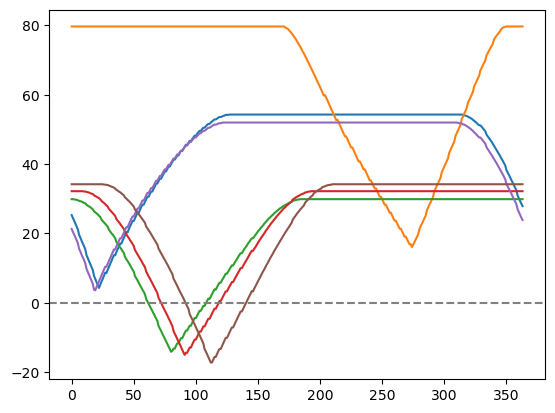

In [326]:
for i in range(len(starlist)):
    plt.plot(starMaxAltList[i])
plt.axhline(y=0.0, color='gray', linestyle='--')
plt.show()

In [348]:

#starlist
#starMaxAltList[0]
starMaxAltList[4]

array([21.3, 20.5, 19.7, 18.9, 18.1, 17.2, 15.6, 14.8, 13.9, 13.1, 12.3,
       11.4,  9.8,  8.9,  8.1,  7.2,  6.4,  5.5,  3.8,  3.6,  4.5,  5.3,
        6.2,  7. ,  7.9,  8.7,  9.6, 10.4, 10.4, 11.2, 12.1, 12.9, 13.7,
       14.5, 15.4, 15.4, 16.2, 17. , 17.8, 18.6, 18.6, 19.4, 20.2, 21. ,
       21.8, 21.8, 22.6, 23.4, 24.2, 24.9, 24.9, 25.7, 26.5, 27.2, 27.2,
       28. , 28.7, 29.5, 29.5, 30.2, 31. , 31.7, 31.7, 32.4, 33.1, 33.1,
       33.8, 34.5, 35.2, 35.2, 35.9, 36.6, 36.6, 37.2, 37.9, 38.5, 38.5,
       39.2, 39.8, 39.8, 40.4, 41. , 41.6, 41.6, 42.2, 42.8, 42.8, 43.3,
       43.9, 43.9, 44.4, 44.9, 45.4, 45.4, 45.9, 46.4, 46.4, 46.9, 47.3,
       47.7, 47.7, 48.1, 48.5, 48.9, 48.9, 49.3, 49.6, 49.6, 49.9, 50.2,
       50.5, 50.5, 50.7, 51. , 51.2, 51.4, 51.4, 51.5, 51.7, 51.8, 51.8,
       51.9, 52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. ,
       52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. , 52. ,
       52. , 52. , 52. , 52. , 52. , 52. , 52. , 52

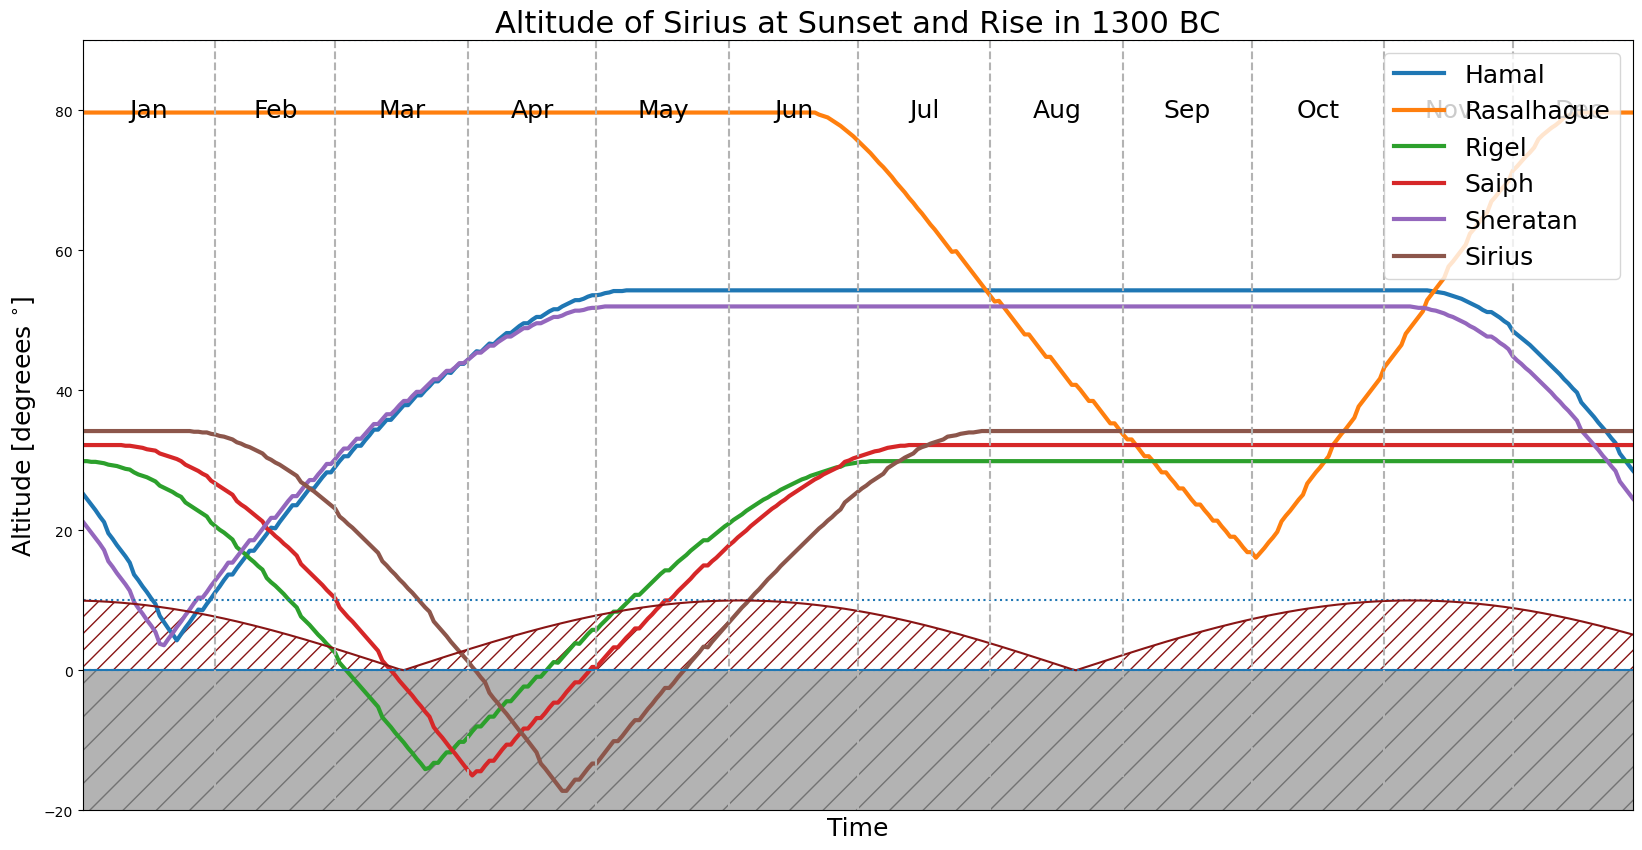

In [335]:
plt.figure(figsize=(20,10))

# plt.plot(xdays, SirSetAlt,  linewidth=3.0, label = 'Sunset')
# plt.plot(xdays, SirRiseAlt,  linewidth=3.0, label = 'Sunrise')

for i in range(len(starlist)):
    plt.plot(xdays, starMaxAltList[i], linewidth=3.0, label = starlist[i])

# landscaping
plt.hlines(0, 0, 366)
plt.hlines(10, 0, 366, linestyle = ':')

xdays = np.arange(1, 365)
y1 = np.abs(10 * np.sin(0.02 * xdays + 29.9))

# this makes the "mountain" effect
plt.plot(xdays, y1, color="#891515")
plt.fill_between(xdays, 0, y1,  facecolor="none", hatch="//", edgecolor="#891515", linewidth=0.0)
plt.fill_between(xdays, -30, 0, facecolor="0.7", hatch="/", edgecolor="0.45", linewidth=0.0)


# NESW LINES
ycoords = np.cumsum([-360, 90, 90, 90, 90, 90, 90, 90])
for yc in ycoords:
    plt.hlines(yc, 0, 366, linestyle = ':')

# month lines
mnth = [1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
mnth_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
xcoords = np.cumsum(mnth) # vertical month lines
for xc in xcoords:
    plt.axvline(x=xc, linestyle = '--', color='0.7' )
    
# month labels

for i in range(0, 12):
    plt.text(xcoords[i + 1] - mnth[i+1]/2, 80, mnth_names[i], fontsize=18, horizontalalignment='center', verticalalignment='center')
    

#plt.fill_between(xdays[120 : 130 + 54 + 1], -360, 360,  facecolor="0.7", hatch="/", edgecolor="0.45", linewidth=0.0)    

 
# label shaded areas
#plt.text(153, 41, "Under the horizon", fontsize = '22',horizontalalignment='center', verticalalignment='center')    
 
    
# no x-label
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# niceties
plt.title('Altitude of Sirius at Sunset and Rise in 1300 BC', fontsize=22)    
plt.ylabel(r'Altitude [degreees $^{\circ}$]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.xlim(1, 363)
plt.ylim(-20, 90)
plt.legend(fontsize = 18)
plt.show()

Ok, so far this looks feasible! 

ALSO, want to kill the data when the decan rises during the daytime!

In [245]:
# plt.plot(sunAzSet - 180)
# for i in range(0, num_decs):
#     plt.plot(starAzRiseList[i])
    

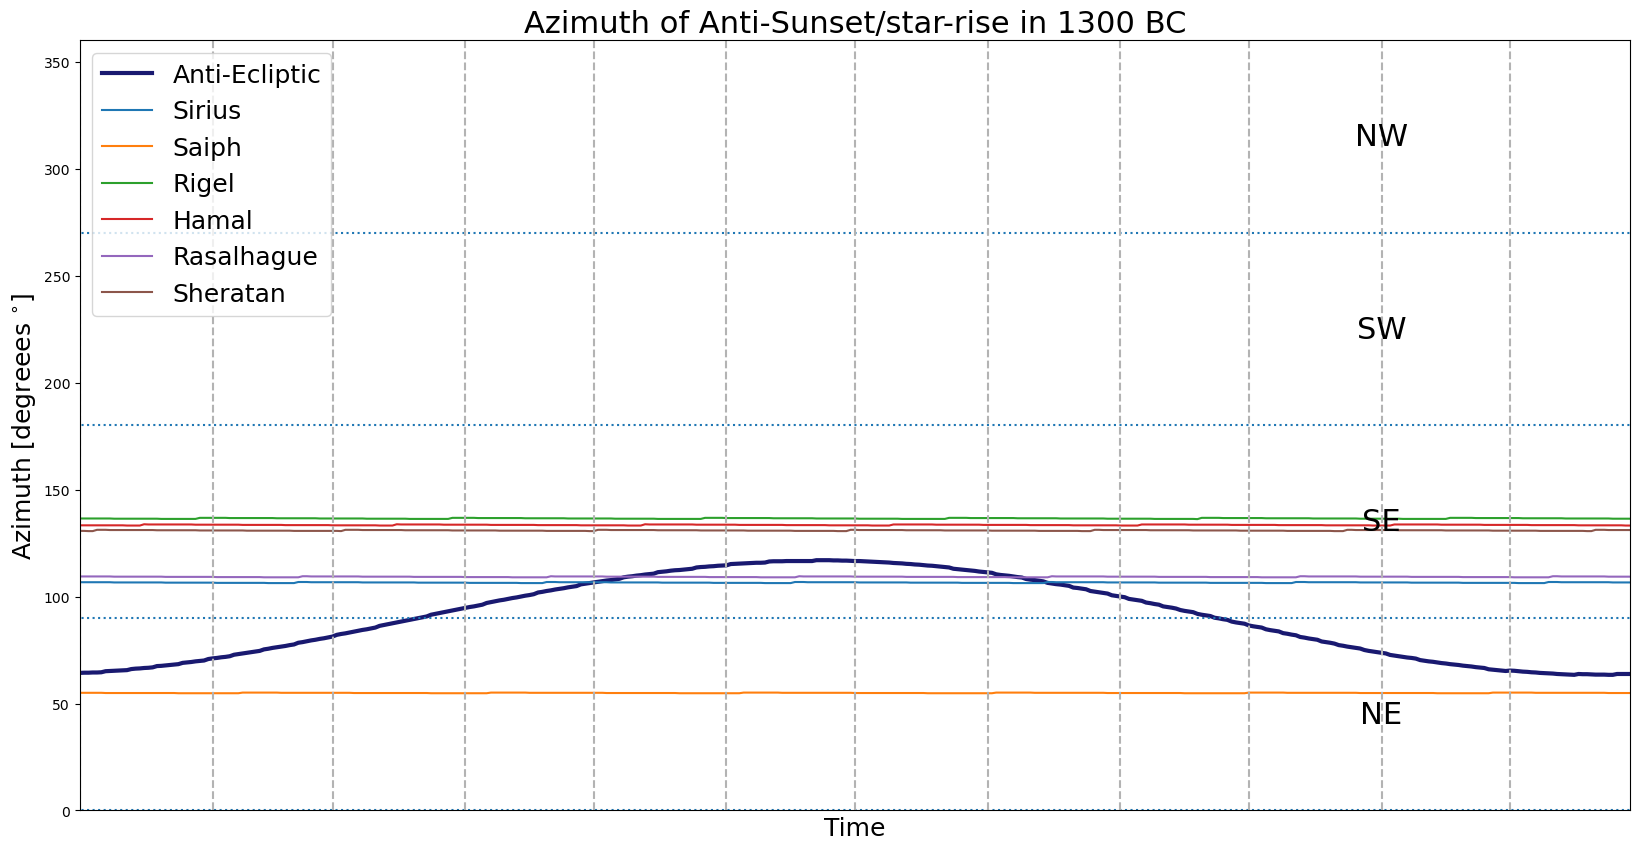

In [259]:
### definitions for plotting

xdays = np.arange(1, len(sunAzSet)+1)
antiEc = sunAzSet - 180

### plot

plt.figure(figsize=(20,10))

plt.plot(xdays, antiEc,  linewidth=3.0, label = 'Anti-Ecliptic', color="midnightblue")
#plt.plot(xdays, sunAzSet,  linewidth=3.0, label = 'Ecliptic', color="orange")

#plt.plot(xdays, np.array(DecAz12[0]), label = starlist[0])

for i in range(0, num_decs):
    plt.plot(xdays, starAzRiseList[i], label = starlist[i])

# NESW LINES
ycoords = np.cumsum([-360, 90, 90, 90, 90, 90, 90, 90])
for yc in ycoords:
    plt.hlines(yc, 0, 366, linestyle = ':')
    
# NESW labels 
xNESF = sum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31])
plt.text(xNESF, 90/2, "NE", fontsize=22, horizontalalignment='center', verticalalignment='center')
plt.text(xNESF, 90 + 90/2, "SE", fontsize=22, horizontalalignment='center', verticalalignment='center')
plt.text(xNESF, 180 + 90/2, "SW", fontsize=22, horizontalalignment='center', verticalalignment='center')
plt.text(xNESF, 270 + 90/2, "NW", fontsize=22, horizontalalignment='center', verticalalignment='center')

# month lines
xcoords = np.cumsum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # vertical month lines
for xc in xcoords:
    plt.axvline(x=xc, linestyle = '--', color='0.7' )

#plt.fill_between(xdays[120 : 130 + 54 + 1], -360, 360,  facecolor="0.7", hatch="/", edgecolor="0.45", linewidth=0.0)
# label shaded areas
#plt.text(153, 200, "Under the horizon", fontsize = '22',horizontalalignment='center', verticalalignment='center')    
        
    
# no x-label
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# niceties
plt.title('Azimuth of Anti-Sunset/star-rise in 1300 BC', fontsize=22)    
plt.ylabel(r'Azimuth [degreees $^{\circ}$]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.xlim(1, 363)
plt.ylim(0, 360)
plt.legend(fontsize = 18)
plt.show()

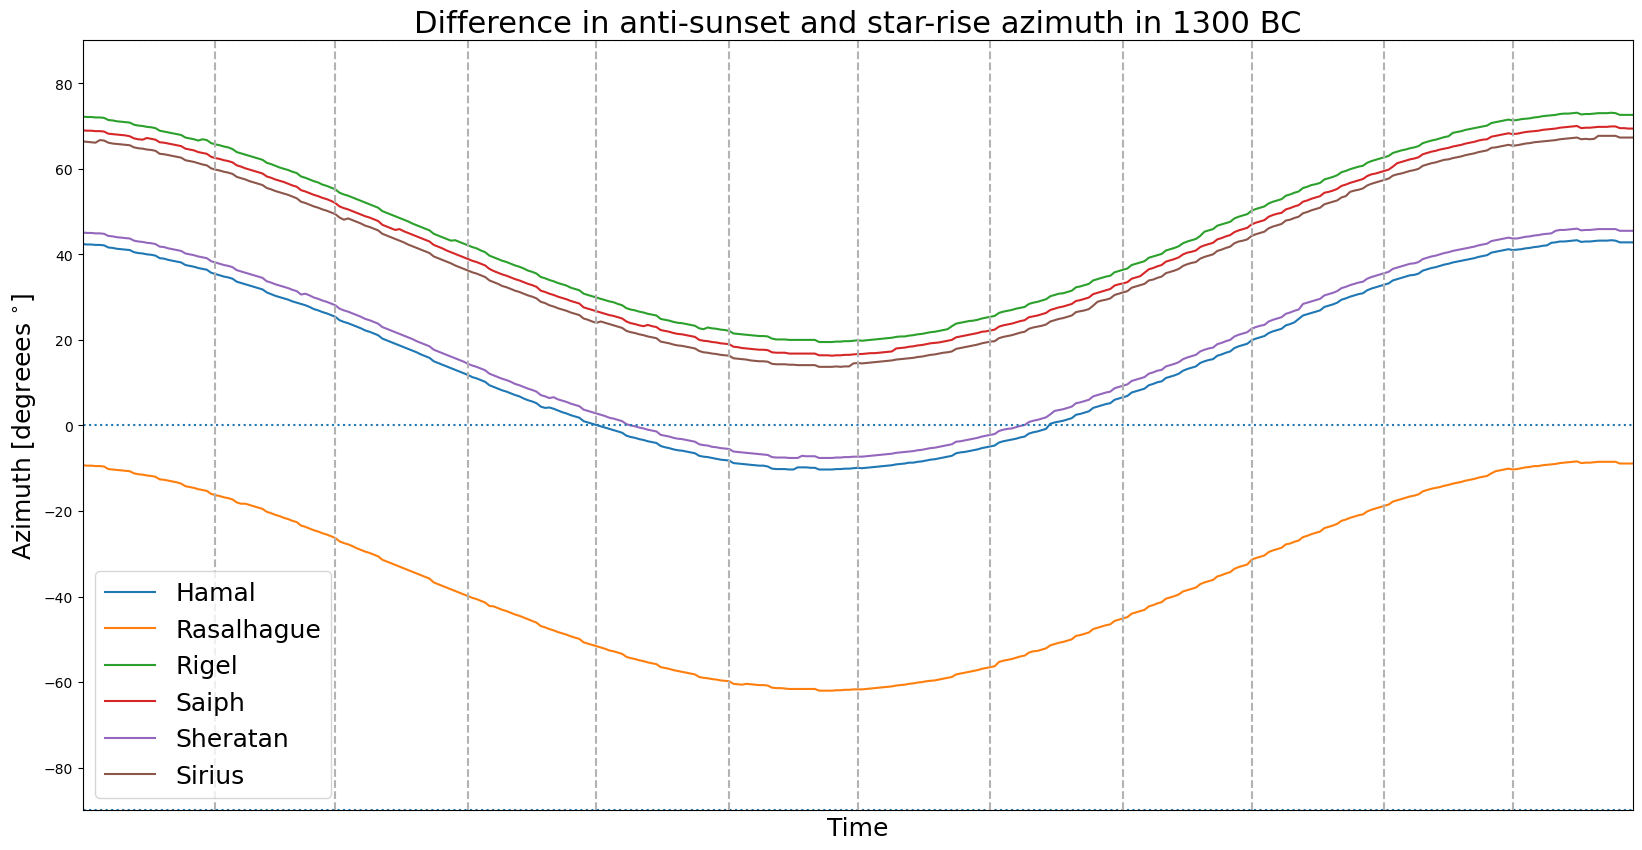

In [336]:
### definitions for plotting

xdays = np.arange(1, len(sunAzSet)+1)
antiEc = sunAzSet - 180

### plot

plt.figure(figsize=(20,10))

#plt.plot(xdays, antiEc,  linewidth=3.0, label = 'Anti-Ecliptic', color="midnightblue")

for i in range(0, num_decs):
    plt.plot(xdays, starAzRiseList[i] - antiEc, label = starlist[i])

# NESW LINES
ycoords = np.cumsum([-360, 90, 90, 90, 90, 90, 90, 90])
for yc in ycoords:
    plt.hlines(yc, 0, 366, linestyle = ':')
    
# # NESW labels 
# xNESF = sum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31])
# plt.text(xNESF, 90/2, "NE", fontsize=22, horizontalalignment='center', verticalalignment='center')
# plt.text(xNESF, 90 + 90/2, "SE", fontsize=22, horizontalalignment='center', verticalalignment='center')
# plt.text(xNESF, 180 + 90/2, "SW", fontsize=22, horizontalalignment='center', verticalalignment='center')
# plt.text(xNESF, 270 + 90/2, "NW", fontsize=22, horizontalalignment='center', verticalalignment='center')

# month lines
xcoords = np.cumsum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # vertical month lines
for xc in xcoords:
    plt.axvline(x=xc, linestyle = '--', color='0.7' )

#plt.fill_between(xdays[120 : 130 + 54 + 1], -360, 360,  facecolor="0.7", hatch="/", edgecolor="0.45", linewidth=0.0)
# label shaded areas
#plt.text(153, 200, "Under the horizon", fontsize = '22',horizontalalignment='center', verticalalignment='center')    
        
    
# no x-label
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# niceties
plt.title('Difference in anti-sunset and star-rise azimuth in 1300 BC', fontsize=22)    
plt.ylabel(r'Azimuth [degreees $^{\circ}$]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.xlim(1, 363)
plt.ylim(-90, 90)
plt.legend(fontsize = 18)
plt.show()

TO DO: Want to try to match this observational behavior to Sirius/Sopdet in the actual tables. 

First thing: make evident when the star is not visible AT ALL during the year. 

Then, try to match up this year to the year as described by the data. There is a sheet in the Excel spreadsheet on Dropbox that is useful for converting Gregorian / Julian / Egyptian years!

In [349]:
import star_chart_spherical_projection as scsp

#["Hamal", "Rasalhague", "Rigel", "Saiph", "Sheratan","Sirius"]

scsp.finalPositionOfStars(userListOfStars=["Hamal"], yearSince2000=-3301,)

{'Hamal': {'Declination': 5.291888926629072, 'RA': '23.15.28'}}

# Scratch

In [344]:

# get sunrise and sunset times
sunriseset = SunRiseSet(jd, sunAlt, 0)
npsunriseset = np.array(sunriseset)
sunAzSet = sunAz[npsunriseset[:,1]]

# for i in range(0, num_decs):
#     (days, minaz, maxaz, minalt, maxalt, riseaz, setaz, risealt, setalt) = MaxMinAltAz(jd, sunriseset, DecAz, DecAlt)

# test for just one
# right now this is giving me rise and set at SUNSET, but want it at STARRISE
(days, minaz, maxaz, minalt, maxalt, riseaz, setaz, risealt, setalt) = MaxMinAltAz(jd, sunriseset, starsAz[0,:], starsAlt[0,:])

In [200]:
# get sunrise and sunset times
sunriseset = SunRiseSet(jd, sunAlt, 0)
npsunriseset = np.array(sunriseset)
sunAzSet = sunAz[npsunriseset[:,1]]

(sunRiseTest, sunSetTest) = StarRiseSet(jd, sunAlt, deg)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [199]:
starAlt = starsAlt[0]
deg = 0

def StarRiseSet(jd, starAlt, deg):
    # create return arrays
    star_rise = np.zeros(int(len(jd)/360))
    star_set = np.zeros(int(len(jd)/360))
    # loop through each day
    for i in range(360, len(jd) + 1, 360):
        print(int((i-360)/360))
        # isolate data for one day
        dailyStarAlt = starAlt[i - 360 : i]
        # is the star visible at the beginning of the day
        starVis = dailyStarAlt[0] > deg
        # make array of booleans
        bool_arr = dailyStarAlt > deg   
        # find two indices of change
        ind1 = np.argwhere(bool_arr != starVis)[0][0]
        ind2 = np.argwhere(bool_arr[ind1:]== starVis)[0][0] + ind1
        # assign indices
        if starVis:
            star_set[int((i-360)/360)] = -360 + i  + ind1
            star_rise[int((i-360)/360)] = -360 + i  + ind2
        else:
            star_set[int((i-360)/360)] = -360 + i  + ind2
            star_rise[int((i-360)/360)] = -360 + i  + ind1
    return (star_rise, star_set)

In [186]:
star_rise

array([ 450.,  809., 1168., 1527., 1886., 2245., 2604., 2963., 3322.,
       3681., 4040., 4399., 4758., 5117.,    0.])

In [170]:
print(dailyStarAlt[85:95])
print(dailyStarAlt[255:265])

[-4.2 -3.3 -2.4 -1.5 -0.6  0.3  1.2  2.1  2.9  3.8]
[ 4.   3.1  2.2  1.3  0.5 -0.4 -1.3 -2.2 -3.1 -4. ]


In [143]:
testAlt = starsAlt[0, 0:360]

bool_arr = testAlt > 0
bool_arr2 = np.array([True, True, False, True])

np.argwhere(bool_arr == False)


array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

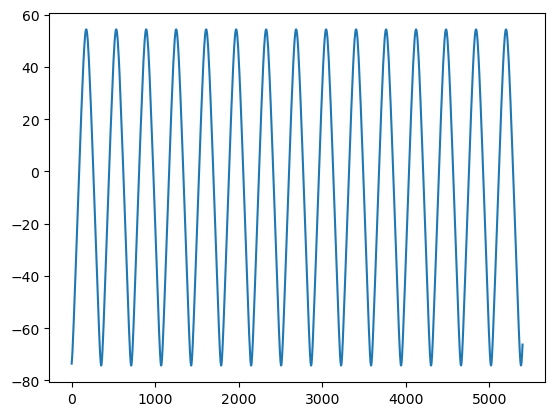

In [141]:
plt.plot(testAlt)

In [121]:
test_arr = np.array([1,2,-3,4,5])
test_arr > 0

array([ True,  True, False,  True,  True])

In [113]:
def StarRiseSet(jd, SunAlt, deg):
    
    '''
    A function to create a list of indices where the Sun rises and sets in a given year. 
    This is useful for making sure we're tracking nightly, visible motion of the decans.
    NOTE: as written, this code assumes that data is collected every 4 minutes. 
    To change this, change number to number of collection intervals per day! (360 = 24 * 60/4)
    Inputs: 
        jd = Julian date
        SunAlt = the altitude of the Sun
    Outputs:
        sunriseset = indices of sunrize and sunset in the jd & date columns
    '''
    
    sunriseset = []
    for i in range(360, len(jd), 360):
        temp = []
        for j in range(i - 360, i):
            if SunAlt[j] <= deg + 0.4 and SunAlt[j] >= deg - 0.4:
                if len(temp) == 0: 
                    temp.append(j)
                elif temp[-1] != j - 1:
                    temp.append(j)
        sunriseset.append(temp)
    return sunriseset

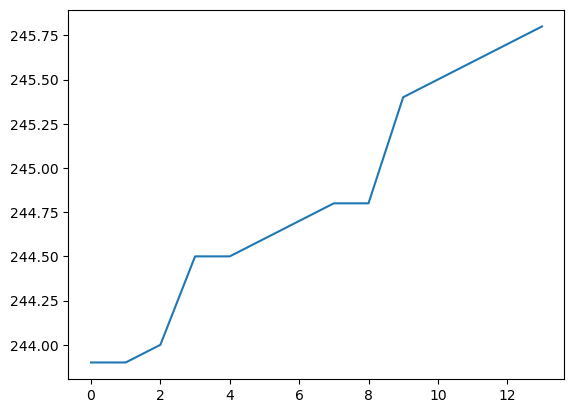

In [98]:
plt.plot(sunAzSet)

[[73, 229],
 [433, 589],
 [793, 949],
 [1153, 1310],
 [1513, 1670],
 [1873, 2030],
 [2233, 2390],
 [2593, 2750],
 [2953, 3110],
 [3313, 3471],
 [3673, 3831],
 [4033, 4191],
 [4393, 4551],
 [4753, 4911]]

In [45]:

i = 0
decanOutput[header[4 + 2 * i]]

0             17.5 deg
1             20.8 deg
2             24.0 deg
3             27.0 deg
4             30.0 deg
              ...     
131395    3.59e+02 deg
131396        2.41 deg
131397        6.04 deg
131398        9.63 deg
131399        13.2 deg
Name: HamalAzimuth, Length: 131400, dtype: object

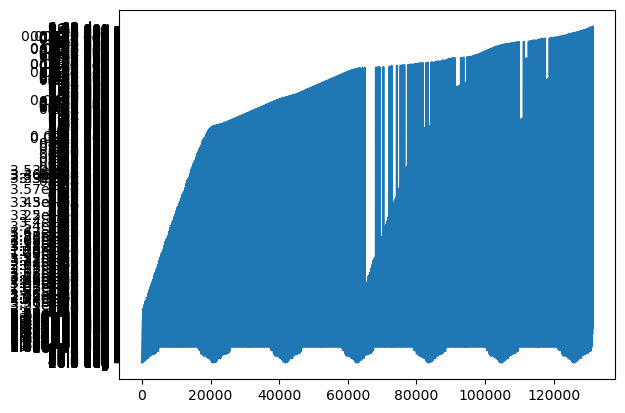

In [46]:
plt.plot(decanOutput[header[4 + 2 * i]])

In [32]:
hrd[128]

'-01300-01-01T08:32:00.000'

## Define Sun Az

In [2]:
### Set the directory

starlist = ["Sirius", "Saiph", "Rigel", "Hamal", "Rasalhague", "Sheratan"]

direct = os.getcwd() # current working directory
direct = direct + '/DecanLists/' # directory where the .txt files go

### import data
filename = "data011300BC.txt"
(jd, date, SunAz, SunAlt, DecanAz, DecanAlt) = ImportDecanData(direct, filename)


In [8]:
### Sun Rise/Set & Azimuths

# for the azimuth of the sun, use sunset/rise az at 0 

sunriseset12 = SunRiseSet(jd, SunAlt, 0)

SunAz12 = []
for i in range(0, len(sunriseset12)):
    temp = sunriseset12[i][1]
    SunAz12.append(SunAz[temp]) 


In [ ]:
### Dec Rise/Set & Azimuths
decriseset12 = []
DecAz12 = []

# when do the stars rise? 10ish? 
# it's not quite a line because it will depend on the brightness of the star
# particularly problematic for hours 0 and 12 (1-11 are probably fine?)

for i in range(0, len(starlist)):
    temp = SunRiseSet(jd, DecanAlt[i], 12)
    decriseset12.append(temp)
    templist = []
    for j in range(0, len(sunriseset12)):
        templist.append(DecanAz[i][temp[j][1]])
    DecAz12.append(templist) 

In [15]:
decriseset

[[90],
 [449],
 [808],
 [1167, 1337],
 [1526, 1696],
 [1885, 2055],
 [2244, 2414],
 [2603, 2773],
 [2962, 3132],
 [3321, 3491],
 [3680, 3850],
 [4039, 4209],
 [4398, 4568],
 [4757, 4927],
 [5116, 5286],
 [5475, 5645],
 [5834, 6004],
 [6193, 6363],
 [6552, 6722],
 [6911, 7081],
 [7270, 7440],
 [7629, 7799],
 [7988, 8158],
 [8347, 8517],
 [8706, 8876],
 [9065, 9235],
 [9424, 9594],
 [9783, 9953],
 [10142, 10312],
 [10501, 10671],
 [10860, 11030],
 [11219, 11389],
 [11578, 11748],
 [11937, 12107],
 [12296, 12466],
 [12655, 12825],
 [13014, 13184],
 [13373, 13543],
 [13732, 13902],
 [14091, 14261],
 [14450, 14620],
 [14809, 14979],
 [15168, 15338],
 [15527, 15697],
 [15886, 16056],
 [16415],
 [16774],
 [17133],
 [17492],
 [17851],
 [18210],
 [18400, 18569],
 [18759, 18928],
 [19118, 19287],
 [19477, 19646],
 [19836, 20005],
 [20195],
 [20554],
 [20913],
 [21272],
 [21631],
 [21990, 22160],
 [22349, 22519],
 [22708, 22878],
 [23067, 23237],
 [23426, 23596],
 [23785, 23955],
 [24144, 24314],

In [17]:
# find azimuth of decan at time of rising

decRiseAz = []
decSetAz = []

for j in range(0, len(starlist)):  
    decAz = DecanAz[j]
    decriseset = SunRiseSet(jd, DecanAlt[j], 0)
    print(len(decriseset))
    riseAztemp = []
    setAztemp = []
    for i in range(3, int(len(jd)/360) - 2):
        print(i)
        dset = decriseset[i][1]
        drise = decriseset[i + 1][0]
        riseAztemp.append(decAz[drise])
        setAztemp.append(decAz[dset])
    decRiseAz.append(riseAztemp)
    decSetAZ.append(setAztemp)

364
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


IndexError: list index out of range

In [4]:
### Dec Rise/Set & Azimuths
decriseset12 = []
DecAz12 = []

# when do the stars rise? 10ish? 
# it's not quite a line because it will depend on the brightness of the star
# particularly problematic for hours 0 and 12 (1-11 are probably fine?)

for i in range(0, len(starlist)):
    temp = SunRiseSet(jd, DecanAlt[i], 12)
    decriseset12.append(temp)
    templist = []
    for j in range(0, len(sunriseset12)):
        templist.append(DecanAz[i][temp[j][1]])
    DecAz12.append(templist)   



In [5]:
DecAz12[0]

[253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 252.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 107.0,
 108.0,


In [237]:
decriseset12[0]

[[76, 273],
 [435, 632],
 [794, 991],
 [1153, 1350],
 [1512, 1709],
 [1871, 2068],
 [2230, 2427],
 [2589, 2786],
 [2948, 3145],
 [3307, 3504],
 [3666, 3863],
 [4025, 4222],
 [4384, 4581],
 [4743, 4940],
 [5102, 5299],
 [5462, 5658],
 [5821, 6017],
 [6180, 6376],
 [6539, 6735],
 [6898, 7094],
 [7257, 7453],
 [7616, 7812],
 [7975, 8171],
 [8334, 8530],
 [8693, 8889],
 [9052, 9248],
 [9411, 9607],
 [9770, 9966],
 [10129, 10325],
 [10488, 10684],
 [10847, 11043],
 [11206, 11402],
 [11565, 11761],
 [11924, 12120],
 [12283, 12480],
 [12642, 12839],
 [13001, 13198],
 [13360, 13557],
 [13719, 13916],
 [14078, 14275],
 [14437, 14634],
 [14796, 14993],
 [15155, 15352],
 [15514, 15711],
 [15873, 16070],
 [16232, 16429],
 [16591, 16788],
 [16950, 17147],
 [17309, 17506],
 [17668, 17865],
 [18027, 18224],
 [18386, 18583],
 [18745, 18942],
 [19104, 19301],
 [19463, 19660],
 [19822, 20019],
 [20181, 20378],
 [20540, 20737],
 [20899, 21096],
 [21258, 21455],
 [21617, 21814],
 [21976, 22173],
 [22335, 

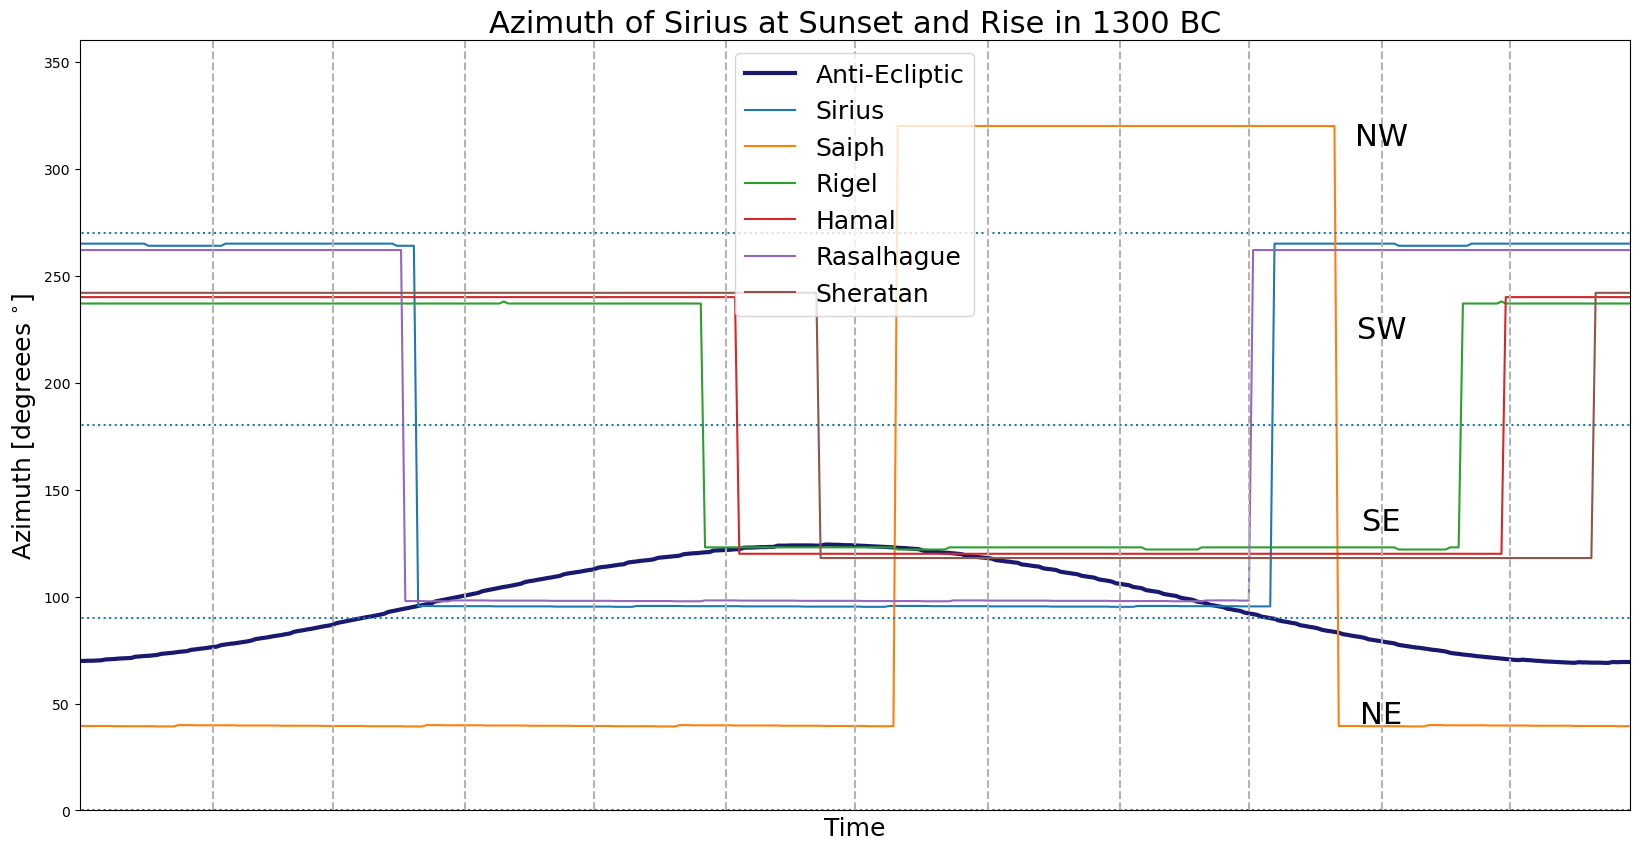

In [236]:
### definitions for plotting

xdays = np.arange(1, len(SunAz12)+1)
antiEc = np.array(SunAz12) - 180

### plot

plt.figure(figsize=(20,10))

plt.plot(xdays, antiEc,  linewidth=3.0, label = 'Anti-Ecliptic', color="midnightblue")

#plt.plot(xdays, np.array(DecAz12[0]), label = starlist[0])

for i in range(0, len(starlist)):
    plt.plot(xdays, np.array(DecAz12[i]), label = starlist[i])

# NESW LINES
ycoords = np.cumsum([-360, 90, 90, 90, 90, 90, 90, 90])
for yc in ycoords:
    plt.hlines(yc, 0, 366, linestyle = ':')
    
# NESW labels 
xNESF = sum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31])
plt.text(xNESF, 90/2, "NE", fontsize=22, horizontalalignment='center', verticalalignment='center')
plt.text(xNESF, 90 + 90/2, "SE", fontsize=22, horizontalalignment='center', verticalalignment='center')
plt.text(xNESF, 180 + 90/2, "SW", fontsize=22, horizontalalignment='center', verticalalignment='center')
plt.text(xNESF, 270 + 90/2, "NW", fontsize=22, horizontalalignment='center', verticalalignment='center')

# month lines
xcoords = np.cumsum([1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) # vertical month lines
for xc in xcoords:
    plt.axvline(x=xc, linestyle = '--', color='0.7' )

#plt.fill_between(xdays[120 : 130 + 54 + 1], -360, 360,  facecolor="0.7", hatch="/", edgecolor="0.45", linewidth=0.0)
# label shaded areas
#plt.text(153, 200, "Under the horizon", fontsize = '22',horizontalalignment='center', verticalalignment='center')    
        
    
# no x-label
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# niceties
plt.title('Azimuth of Sirius at Sunset and Rise in 1300 BC', fontsize=22)    
plt.ylabel(r'Azimuth [degreees $^{\circ}$]', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.xlim(1, 363)
plt.ylim(0, 360)
plt.legend(fontsize = 18)
plt.show()

In [ ]:





# List of Sunset Azimuths 
for i in range(0, len(sunriseset12)):
    temp = sunriseset12[i][1]
    SunAz12.append(SunAz[temp]) 
    for j in range(0, len(starlist)):
        temp = decriseset12[j][i]
        print(temp)
        #DecAz12[j, i] = DecAz12[j, temp]

